Policy Gradient (Action / Critics)

In [37]:
import torch
import torch.nn as nn
import gymnasium as gym 
import numpy as np 

import torch.optim as optim

from sklearn.preprocessing import StandardScaler

# distribution functions 
from torch.distributions import Categorical 

import sys
sys.path.append('../')


In [48]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()

        self.fnn = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax()
        )

        # storing the log probability distribution
        self.log_probabilities = []
        
        # storing the rewards for each step
        self.rewards = []

    def reset(self):
        """ Internal reset """
        self.log_probabilities = []
        self.rewards = []

    def forward(self, state):
        action_logits = self.fnn(state)

        return action_logits
    
    def tensor(self, obs):
        return torch.FloatTensor(obs)
    
    @torch.no_grad()
    def predict(self, obs):
        obs_tensor = self.tensor(obs)
        probs = self.fnn(obs_tensor)
        action = torch.argmax(probs).item()
        return action

    def generate_q_table(self, usable_ace=False):
        """Generate a tabular Q-value dict for plotting."""
        self.q_values = {}
        for player_sum in range(5, 22):
            for dealer_card in range(1, 11):
                state = (player_sum, dealer_card, usable_ace)
                state_tensor = self.tensor(state)
                q_vals = self.predict(state_tensor)
                self.q_values[state] = q_vals

In [49]:
# Value Function as B
class Value(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.net(state).squeeze(-1) 

env = gym.make("Blackjack-v1")
policy = Policy(3, 2)
value_net = Value(3)

policy_optimizer = torch.optim.Adam(policy.parameters(), lr=0.0005)
value_optimizer = torch.optim.Adam(value_net.parameters(), lr=0.0005)

gamma = 0.5
batch_size = 32
epoches = 10_000
best_reward = -np.inf
break_counter = 0

episode_rewards = []

for epoch in range(epoches):
    if break_counter >= 200:
        break

    batch_policy_loss = []
    batch_value_loss = []
    batch_episode_reward = []

    for _ in range(batch_size):
        obs = env.reset()[0]
        done = False

        states = []
        actions = []
        rewards = []
        log_probs = []

        while not done:
            state_tensor = torch.FloatTensor(obs)
            probs = policy(state_tensor)
            dist = Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            obs, reward, done, _, _ = env.step(action.item())

            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)

        # Compute discounted returns
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns, dtype=torch.float32)
        states = torch.stack(states)
        log_probs = torch.stack(log_probs)

        # advantages
        values = value_net(states).detach()

        # so here we use advantage A instead of Gt to calculate the policy loss 
        # A measures the advantage of using the new policy over the baseline performance determine by our value estimator
        # this approach will control the variance incase the Monte Carlo Estimations falls into a loop where all hits are busts...
        # and the model will see -1 rewards continously...
        advantages = returns - values

        # Policy loss (Actor): -log_pi * advantage

        """
        If policy sticks too early... then it will always stick.
        For example if it always bust when e< 100 then it will always stick after 100....

        Entropy measures the randomness of the softmax layer 
        high entropy = more random
        low entropy = more deterministic
        
        so we boost up the entrop here to give more reward if the distribution is more random...

        Shannon’s Entropy is a measure of uncertainty:

        > probs[1]*np.log(probs[1].item()) + probs[0]*np.log(probs[0].item()) 
        > the Categorical class has the build in method os entropy(), which is very convenient !!
        
        """
        entropy = dist.entropy()
        policy_loss = -(log_probs * advantages).sum() - 0.05 * entropy.sum()

        batch_policy_loss.append(policy_loss)

        # Value loss (Critic): MSE between return and value
        value_predictions = value_net(states)
        value_loss = nn.functional.mse_loss(value_predictions, returns)
        batch_value_loss.append(value_loss)

        batch_episode_reward.append(sum(rewards))

    # Update policy
    total_policy_loss = torch.stack(batch_policy_loss).mean()
    policy_optimizer.zero_grad()
    total_policy_loss.backward()
    policy_optimizer.step()

    # Update value network
    total_value_loss = torch.stack(batch_value_loss).mean()
    value_optimizer.zero_grad()
    total_value_loss.backward()
    value_optimizer.step()

    # Logging
    avg_reward = np.mean(batch_episode_reward)
    episode_rewards.append(avg_reward)
    if epoch > 100:
        print(f"Epoch {epoch} | Avg Reward (last 100): {np.mean(episode_rewards[-100:]):.2f}")

    if avg_reward > best_reward:
        best_reward = avg_reward
        torch.save(policy.state_dict(), '../checkpoints/actor_critic_policy.pth')
        torch.save(value_net.state_dict(), '../checkpoints/actor_critic_value.pth')
        break_counter = 0
    else:
        break_counter += 1


Epoch 101 | Avg Reward (last 100): -0.21
Epoch 102 | Avg Reward (last 100): -0.21
Epoch 103 | Avg Reward (last 100): -0.20
Epoch 104 | Avg Reward (last 100): -0.20
Epoch 105 | Avg Reward (last 100): -0.20
Epoch 106 | Avg Reward (last 100): -0.20
Epoch 107 | Avg Reward (last 100): -0.19
Epoch 108 | Avg Reward (last 100): -0.19
Epoch 109 | Avg Reward (last 100): -0.20
Epoch 110 | Avg Reward (last 100): -0.20
Epoch 111 | Avg Reward (last 100): -0.19
Epoch 112 | Avg Reward (last 100): -0.19
Epoch 113 | Avg Reward (last 100): -0.19
Epoch 114 | Avg Reward (last 100): -0.19
Epoch 115 | Avg Reward (last 100): -0.19
Epoch 116 | Avg Reward (last 100): -0.19
Epoch 117 | Avg Reward (last 100): -0.19
Epoch 118 | Avg Reward (last 100): -0.19
Epoch 119 | Avg Reward (last 100): -0.19
Epoch 120 | Avg Reward (last 100): -0.19
Epoch 121 | Avg Reward (last 100): -0.18
Epoch 122 | Avg Reward (last 100): -0.19
Epoch 123 | Avg Reward (last 100): -0.18
Epoch 124 | Avg Reward (last 100): -0.19
Epoch 125 | Avg 

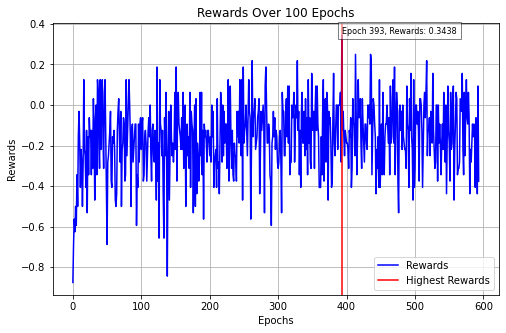

In [50]:
import matplotlib.pyplot as plt

# Ensure both lists have the same length
epochs = list(range(1, len(episode_rewards) + 1))

# Find min loss points
min_train_index = episode_rewards.index(max(episode_rewards))

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(episode_rewards, label="Rewards", linestyle='-', color='blue')

# Add vertical lines at minimum loss points
plt.axvline(x=min_train_index, color='red', linestyle='-', label='Highest Rewards')

# Add text labels at min loss points
plt.text(min_train_index, max(episode_rewards), 
         f'Epoch {min_train_index}, Rewards: {max(episode_rewards):.4f}', 
         ha='left', va='bottom', fontsize=8, 
         bbox={'facecolor': 'white', 'alpha': 0.5})

# Labels, legend, and grid
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.title("Rewards Over 100 Epochs")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [58]:
from modules.utils import * 

policy.load_state_dict(torch.load('../checkpoints/actor_critic_policy.pth'))

policy.generate_q_table()

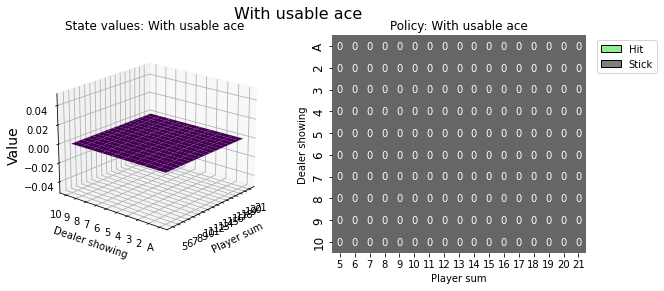

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
from collections import defaultdict
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = action_values
        policy[obs] = action_values

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(5, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid
    

def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(5, 22), range(5, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(5, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

value_grid, policy_grid = create_grids(policy, usable_ace=True)
fig = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()
policy_grid


In [61]:
usable_ace = True
policy_grid = defaultdict(int)
for obs, action_values in policy.q_values.items():
    policy_grid[obs] = action_values

player_count, dealer_count = np.meshgrid(
    # players count, dealers face-up card
    np.arange(12, 22),
    np.arange(1, 11),
)

# create the policy grid for plotting
policy_grid = np.apply_along_axis(
    lambda obs: policy_grid[(obs[0], obs[1], usable_ace)],
    axis=2,
    arr=np.dstack([player_count, dealer_count]),
)

np.save('../checkpoints/AC_Policy_Gradient.npy', policy_grid)
policy_grid

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [44]:
basic_strategy_grid = np.array([
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],  # Dealer shows Ace
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 4
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 5
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 6
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 7
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 8
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 9
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Dealer shows 10
])

coverage = policy_grid == basic_strategy_grid
coverage_pcnt = np.sum(coverage) / coverage.size * 100
print(f"Policy matches basic strategy on {np.sum(coverage)}/{coverage.size} cells")
print(f"Coverage: {coverage_pcnt:.2f}%")

Policy matches basic strategy on 49/100 cells
Coverage: 49.00%
